<a href="https://colab.research.google.com/github/srilavanyasubramanian/srilavanyasubramanian/blob/main/GANexer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import  time
from IPython import display

In [2]:
(train_images,train_labels),(_, _) = tf.keras.datasets.mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5)/127.5


In [4]:
BUFFER_SIzE = 60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIzE).batch(BATCH_SIZE)


In [10]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7,7,256)

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias = False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias = False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias = False,activation='tanh'))
  assert model.output_shape == (None,28,28,1)

  return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


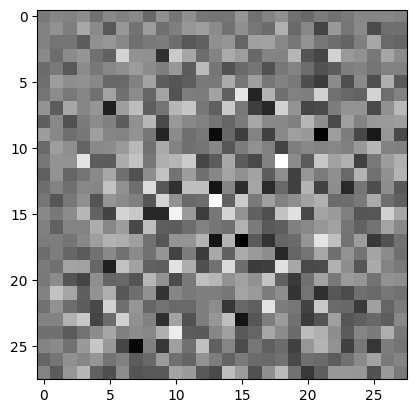

In [11]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0, :, :, 0],cmap='gray' )


In [12]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model



In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00040771]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
check_point_dir = './training_checkpoints'
check_point_prefix = os.path.join(check_point_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator= generator,
                                 discriminator = discriminator)